In [2]:
import matplotlib.pyplot as plt
import numpy as np
import math

Here, we compare the results of calculated heralding efficiency from spdcalc and the methods used in Ryan Bennink's paper. These calculations are based on a parameter related to focusing for each of the photons,

$$ \xi_j = \frac{L}{k_jw_j^2}, $$

where $w_j$ is the waist size for a given photon. 

We calculate heralding efficiency by considering

$$ P_{si} \approx \frac{64\pi^3\hbar c \epsilon n_s n_i}{\epsilon_0 n_p |n_s'-n_i'|} \left( \frac{\chi^{(2)}_{\textrm{eff}}}{\lambda_s\lambda_i}  \right)^2\frac{\arctan(\xi)}{A_+B_+} N_p $$

and 

$$ P_{s} \approx \frac{64\pi^3\hbar c \epsilon n_s n_i}{\epsilon_0 n_p |n_s'-n_i'|} \left( \frac{\chi^{(2)}_{\textrm{eff}}}{\lambda_s\lambda_i}  \right)^2\frac{\arctan(\xi_s B_s/A_s)}{A_sB_s} N_p, $$

so that the heralding efficiency $\eta_i = P_{si}/P_s$ is

$$ \frac{\arctan(\xi)}{A_+B_+} \frac{A_s B_s}{\arctan(\frac{B_s}{A_s}\xi_s)} $$.

We begin by calculating the focusing parameter and the momentum of each photon, assuming that $\lambda_s=\lambda_i = 1550$ nm and that $\lambda_p = 775$ nm. 

In [3]:
lambda_p = 775e-9
lambda_s = 1550e-9
lambda_i = 1550e-9

theta = np.radians(90)

L = 2000e-6

KDP_o = [2.259276,13.005522,400,0.01008956,0.012942625]
KDP_e = [2.132668,3.2279924,400,0.008637494,0.012281043]

def axisIndex(wavelength, sellmeier):
    wavelength = wavelength/1000
    n_1 = sellmeier[0]
    n_2 = sellmeier[1]*(wavelength**2)/((wavelength**2)-sellmeier[2])
    n_3 = sellmeier[3]/((wavelength**2)-sellmeier[4])
    return np.sqrt(n_1+n_2+n_3)

def refIndex(theta, phi, wavelength, fast):
    theta = np.radians(theta)
    s_x=np.sin(theta)*np.cos(phi)
    s_y=np.sin(theta)*np.sin(phi)
    s_z=np.cos(theta)
    n_x = n_y = axisIndex(wavelength,KDP_o)
    n_z = axisIndex(wavelength,KDP_e)
        
    b = (s_x**2)*((n_y**-2)+(n_z**-2))+(s_y**2)*((n_x**-2)+(n_z**-2))+(s_z**2)*((n_x**-2)+(n_y**-2))
    c = (s_x**2)*(n_y**-2)*(n_z**-2)+(s_y**2)*(n_x**-2)*(n_z**-2)+(s_z**2)*(n_x**-2)*(n_y**-2)
    if fast == True:
        x = (b+np.sqrt((b**2)-4*c))/2
    else:
        x = (b-np.sqrt((b**2)-4*c))/2
    return np.sqrt(1/x)

n_s = refIndex(theta, 0, lambda_s, True)
n_i = refIndex(theta, 0, lambda_i, False)
n_p = refIndex(theta, 0, lambda_p, True)

waist_s = 100e-6
waist_i = 100e-6
waist_p = 100e-6
waist = np.linspace(1e-6, 130e-6, 130)

h_bar = 1.054571817e-34
k_p = 2*math.pi*h_bar*n_p/lambda_p
k_s = 2*math.pi*h_bar*n_s/lambda_s
k_i = 2*math.pi*h_bar*n_i/lambda_i

dk = k_p-k_s-k_i

focus_s = L/(k_s*waist_s**2)
focus_i = L/(k_i*waist_i**2)
focus_p = L/(k_p*waist_p**2)
focus = L/(k_s*waist**2)

Next, construct a series of functions to calculate the parameters $A_+,\ B_+,\ A_s,\ B_s,\ \xi$ so that their results can be used as parameters in the heralding calculation function. We calculate these according to the following equations.

$$ A_+ = 1 + \frac{k_s}{k_p}\frac{\xi_s}{\xi_p} + \frac{k_i}{k_p} \frac{\xi_i}{\xi_p} $$

$$ B_+ = \left(1-\frac{\Delta k }{k_p}\right) \left(1 + \frac{k_s+\Delta k}{k_p-\Delta k} \frac{\xi_p}{\xi_s} + \frac{k_i+\Delta k}{k_p-\Delta k} \frac{\xi_p}{\xi_i} \right) $$

$$ \xi = \frac{B_+}{A_+}\frac{\xi_s\xi_i}{\xi_p} $$

$$ A_s = 2\sqrt{\left(1 + \frac{k_s}{k_p}\frac{\xi_s}{\xi_p}\right)\frac{k_i}{k_p}} $$

$$ B_s = 2\left(1 - \frac{k_s+ \Delta k}{k_p - \Delta k}\right) \sqrt{\left(1 + \frac{k_s+\Delta k}{k_p - \Delta k} \frac{\xi_p}{\xi_s}\right)\frac{k_i+\Delta k}{k_p - \Delta k}} $$

In [4]:
def A_plus(focus_s, focus_i, focus_p):
    a = 1 + (k_s*focus_s)/(k_p*focus_p) + (k_i*focus_i)/(k_p*focus_p)
    return a

def B_plus(focus_s, focus_i, focus_p):
    b = (1-dk/k_p)*(1+focus_p*(k_s+dk)/((k_p-dk)*focus_s)+focus_p*(k_i+dk)/((k_p-dk)*focus_i))
    return b

def focus_agg(focus_s, focus_i, focus_p):
    z = B_plus(focus_s, focus_i, focus_p)*focus_s*focus_i/(A_plus(focus_s,focus_i,focus_p)*focus_p)
    return z

def A_s(focus_s, focus_i, focus_p):
    a = 2 * np.sqrt( (1 + k_s*focus_s / (k_p*focus_p) ) *k_i/k_p )
    return a

def B_s(focus_s, focus_i, focus_p):
    b = 2 * (1-dk/k_p) * np.sqrt( ( 1 + (k_s+dk)*focus_p / ( (k_p-dk)*focus_s) ) * (k_i+dk)/(k_p-dk) )
    return b

def s_heralding(focus_s, focus_i, focus_p):
    a_s = A_s(focus_s, focus_i, focus_p)
    b_s = B_s(focus_s, focus_i, focus_p)
    a_plus = A_plus(focus_s, focus_i, focus_p)
    b_plus = B_plus(focus_s, focus_i, focus_p)
    focus = focus_agg(focus_s, focus_i, focus_p)
    s = np.arctan(focus) * a_s * b_s / (a_plus*b_plus * np.arctan(b_s*focus_s/a_s))
    return s

Use these results to calculate the signal heralding efficiency when the waist of all three photons is located at the center of the crystal and $100 \mu\textrm{m}$ in length. Compare this to spdcalc's signal heralding efficiency of 0.8896055595101362 for these values, with signal and idler waists not at the center of the crystal. 

In [5]:
print(s_heralding(focus_s, focus_i, focus_p))

0.8606629658238706


Then calculate the heralding efficiency when the pump waist is kept constant at $100 \mu\textrm{m}$ while the signal and idler waist is allowed to vary from 1 to 130 $\mu\textrm{m}$, and plot the results. These can be compared to  <a href="http://wellcaffeinated.net/spdcalc-ui/#/?cfg=eyJhdXRvQ2FsY1RoZXRhIjp0cnVlLMkVUGVyaW9kaWNQb2xpbmfQHkludGVncmF0aW9uTGltaXRzyCFzcGRDb25maWciOnsiY3J5c3RhbCI6IktEUF8xIiwicG1fdHlwZSI6IlR5cGUxX2Vfb28iLMgpX3TmAIo5MMoTcGhpIjrLEGxlbmd0aCI6MjAwyxZ0ZW1wZXJhdHVyZcQbLCJmaWJlcl9jb3Vw7AC%2FcHVtcF93YXZlyEY3NzXHFmJhbmR3aWTEFTUuM8gWd2Fpc3QiOjHEbMURc3BlY3RydW1fdGhyZXNob2xkIjowLjEsInNpZ25hbM1dMTU1MMkZ5wDbyhHoANnHD%2BsAgMxOyn%2FME19wb3Np5AF9IjotNjc2LjUyMzcyNTk4NzcyODEsImlkbGVy8wCLxhjqAIrGEOUAiTE4yRDuAIrITOoAicsS%2FwCIcOcCRF9w5QJFX2VuYWJsZWTpAY7GFsYmIjo1My43NTA1NzQ0MjU4OTM4OCwiYXBvZGl65QJnyj1mYWxz5AKLyxxmd2htIjoxNjAwfSwiaeoCnOoCi2xzX21pbiI6MTQ4MS41MzA3ODA3OTIyM%2BQAp8QcYXjEQDE4LjQ2OTIxOTIwNzc2MiwibGnJNzcuMDg4ODE4ODAwMjIxxDdpyDcyNS4xMDQ1MDU0NjMzMjE25AGtemXlAS99fQ%3D%3D&panels=W3sidHlwZSI6ImhlcmFsZGluZy1jYWxjIiwic2V0dGluZ3MiOnt9fSzTKHYtd3POKCJjb21iaW5lZEpTSUxvZ1NjYWxlIjpmYWxzZSwieGF4acUlbWluIjoiYXV0byIsIm1heCI6MTMwLCJzdGVwcyI6MTB9LCJqc2lSZXNvbHV0aW9uIjrEH8QwVXBkYXRlIjp0cnVl7ACUUGFuZWxMb2FkZXL6ALnbJV0%3D" target="_blank">spdcalc's results.</a>

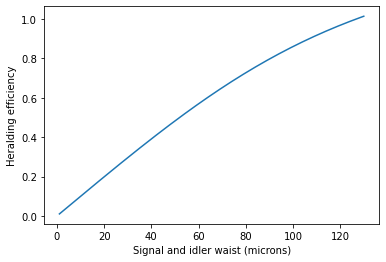

In [7]:
heralding_eff = s_heralding(focus, focus, focus_p)

plt.plot(waist*10**6, heralding_eff)
plt.xlabel("Signal and idler waist (microns)")
plt.ylabel("Heralding efficiency")
plt.show()